In [2]:
import sys
import json
import os.path as op

from mne import read_epochs
from scipy.interpolate import interpolate

from extra.tools import dump_the_dict
from utilities import files
from os import sep
import nibabel as nb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_surface_plotting import plot_surf

In [8]:
def load_results(subj_idx, epo_type):
    # opening a json file
    json_file="settings.json"
    with open(json_file) as pipeline_file:
            parameters = json.load(pipeline_file)

    path = parameters["dataset_path"]

    der_path = op.join(path, "derivatives")
    proc_path = op.join(der_path, "processed")

    subjects = files.get_folders_files(proc_path)[0]
    subjects.sort()

    subject = subjects[subj_idx]
    subject_id = subject.split("/")[-1]
    print("ID:", subject_id)

    sessions = files.get_folders(subject, 'ses', '')[2]
    sessions.sort()

    name='{}-{}'.format(subject_id,epo_type)
    
    subj_results={
        'subj_id': subject_id,
        'epo_type': epo_type,
        'session': [],
        'run': [],
        'mean_res': [],
        'coords': [],
        'pial_mean': [],
        'white_mean': [],
        'f_diff': [],
        'label': [],
        'pial_surf_fname': '',
        'inner_times': [],
        'times': [],
    }
    
    for session in sessions:

        session_id = session.split("/")[-1]

        res_fnames = files.get_files(op.join(session, 'spm'), "invert_fmspm_converted_autoreject", epo_type + "-epo_localizer_results.json")[2]
        res_fnames.sort()

        for run_idx,res_fname in enumerate(res_fnames):

            numero = res_fname.split(sep)[-1].split("-")[5]

            with open(res_fname) as results_file:
                results = json.load(results_file)

            subj_results['session'].append(session_id)
            subj_results['mean_res'].append(run_idx)
            
            pial_idx = results['surfaces'].index('pial')
            pial_res_fname = results['res_fname'][pial_idx]
            pial_res = pd.read_csv(pial_res_fname, sep="\t", header=None).values
            
            
            white_idx = results['surfaces'].index('white')
            white_res_fname = results['res_fname'][white_idx]
            white_res = pd.read_csv(white_res_fname, sep="\t", header=None).values
            
            mean_res = 0.5 * (pial_res + white_res)            
            subj_results['mean_res'].append(mean_res)
            
            pial_surf_fname = results['surf_fname'][pial_idx]
            subj_results['pial_surf_fname'] = pial_surf_fname            
            inflated_pial_surf_fname = op.join(sep.join(pial_surf_fname.split(sep)[0:-1]), 'pial.ds.inflated.nodeep.gii')
            pial_surf = nb.load(inflated_pial_surf_fname)
            pial_vertices, pial_faces = pial_surf.darrays[0].data, pial_surf.darrays[1].data
        
            coords = np.array([pial_vertices[results['peak_idx'], :]])
            print('Session {}, Run {}: {}'.format(session_id, numero, coords))            
            subj_results['coords'].append(coords)
            
            times = np.array(results['times'])
            t_g0 = np.where(times > 0)[0]
            pial_mean = np.array(results['pial_source'])
            white_mean = np.array(results['white_source'])
            max_idx = np.argmax(np.abs(pial_mean[t_g0]))
            if np.mean(np.array([pial_mean[t_g0][max_idx], white_mean[t_g0][max_idx]]),axis=0) > 0:
                pial_mean = -1 * pial_mean
                white_mean = -1 * white_mean
            subj_results['pial_mean'].append(pial_mean)
            subj_results['white_mean'].append(white_mean)
            subj_results['times']=results['times']
            
            tc_fname=op.join(session, 'spm', 'invert_fmspm_converted_autoreject-{}-{}-{}-{}-epo_tc_results.json'.format(subject_id, session_id, numero, epo_type))
            with open(tc_fname) as tc_file:
                tc_results=json.load(tc_file)
            subj_results['inner_times'] = tc_results['times'][tc_results['left_idx'] - 1:tc_results['right_idx']]
            
            f_diff=tc_results['f_diff']
            #f_diff_diff = np.abs(np.diff(f_diff))
            #extrem_idx=np.where(f_diff_diff>3*np.std(f_diff_diff))[0]
            #f_diff[extrem_idx+1]=float('NaN')

            #inds = np.arange(f_diff.shape[0])
            #good = np.where(np.isfinite(f_diff))
            #f = interpolate.interp1d(inds[good], f_diff[good], bounds_error=False)
            #f_diff = np.where(np.isfinite(f_diff), f_diff, f(inds))
            subj_results['f_diff'].append(f_diff)
            
    subj_results['session']=np.array(subj_results['session'])
    subj_results['run']=np.array(subj_results['run'])
    subj_results['coords']=np.squeeze(np.array(subj_results['coords']))
    subj_results['mean_res']=np.mean(np.array(subj_results['mean_res']),axis=0)
    subj_results['pial_mean']=np.array(subj_results['pial_mean'])
    subj_results['white_mean'] = np.array(subj_results['white_mean'])
    subj_results['f_diff'] = np.array(subj_results['f_diff'])

    
    return subj_results

In [17]:
def plot_results(subj_results):    
    
    #coord_colors=[]
    #for i in enumerate(np.unique(
    #cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #c_idx=0
    
            
    pial_surf_fname = subj_results['pial_surf_fname']
    inflated_pial_surf_fname = op.join(sep.join(pial_surf_fname.split(sep)[0:-1]), 'pial.ds.inflated.nodeep.gii')
    pial_surf = nb.load(inflated_pial_surf_fname)
    pial_vertices, pial_faces = pial_surf.darrays[0].data, pial_surf.darrays[1].data
            
    #thresh = np.percentile(subj_results['mean_res'], 99.5)
    
            
    #coord_colors.append(cycle[c_idx])

            

            
    #labels.append('{}-{}'.format(session_id,numero))

    #c_idx=c_idx+1

    
    mean_peak_idx = np.argmax(subj_results['mean_res'])
    mean_coords = np.array([pial_vertices[mean_peak_idx, :]])
    print('Mean: {}'.format(mean_coords))
    
    rotate = [90]
    x_rotate = 270
    if 'motor' in subj_results['epo_type']:
        rotate = [0]
        x_rotate = 0
    elif 'visual' in subj_results['epo_type']:
        rotate = [0]
        x_rotate = -90
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 3, 1, xlim=[-.98, +.98], ylim=[-.98, +.98],
                     aspect=1, frameon=False,
                     xticks=[], yticks=[])
    plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=subj_results['mean_res'], rotate=rotate, x_rotate=x_rotate,
              ax=ax, colorbar=False, cmap='bwr')# alpha_colour=(mean_res > thresh).astype(int))

    ax = plt.subplot(2, 3, 2, xlim=[-.98, +.98], ylim=[-.98, +.98],
                     aspect=1, frameon=False,
                     xticks=[], yticks=[])

    overlay = np.zeros(subj_results['mean_res'].shape)
    overlay[0] = 10
    plot_surf(vertices=pial_vertices, faces=pial_faces, overlay=overlay, rotate=rotate, x_rotate=x_rotate,
              ax=ax, colorbar=False, cmap='jet', alpha_colour=(overlay > 0).astype(int), vmin=0, vmax=4,
              transparency=.25, coords=subj_results['coords'], coord_size=0.01)#, coord_colours=coord_colors)

    plt.subplot(2, 3, 4)
    plt.plot(subj_results['times'], np.mean(subj_results['pial_mean'],axis=0))#, cycle[0])
    plt.plot(subj_results['times'], np.mean(subj_results['white_mean'], axis=0))#, cycle[1])
    err=np.std(subj_results['pial_mean'],axis=0)/np.sqrt(subj_results['pial_mean'].shape[0])
    plt.fill_between(subj_results['times'], np.mean(subj_results['pial_mean'],axis=0) - err, np.mean(subj_results['pial_mean'],axis=0)+err,alpha=0.5)#,color=cycle[0])
    err = np.std(subj_results['white_mean'], axis=0) / np.sqrt(subj_results['white_mean'].shape[0])
    plt.fill_between(subj_results['times'], np.mean(subj_results['white_mean'], axis=0) - err, np.mean(subj_results['white_mean'], axis=0) + err, alpha=0.5)#, color=cycle[1])
    plt.legend(['pial', 'white'])
    plt.xlabel('Time (s)')
    plt.ylabel('Source density (pAm/mm^2)')

    plt.subplot(2, 3, 3)
    m=np.mean(subj_results['pial_mean']-subj_results['white_mean'], axis=0)
    plt.plot(subj_results['times'], m)#, cycle[0])
    err = np.std(subj_results['pial_mean']-subj_results['white_mean'], axis=0) / np.sqrt(subj_results['pial_mean'].shape[0])
    plt.fill_between(subj_results['times'], m - err, m + err,
                     alpha=0.5)#,color=cycle[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Pial-White source density (pAm/mm^2)')

    ax = plt.subplot(2, 3, 5)
    for i in range(subj_results['f_diff'].shape[0]):
        plt.plot(subj_results['inner_times'], subj_results['f_diff'][i,:])#, coord_colors[i], label=labels[i])
    plt.plot(subj_results['inner_times'], np.mean(subj_results['f_diff'], axis=0), 'k--')
    #plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('\Delta F')

    ax = plt.subplot(2, 3, 6)
    plt.plot(subj_results['inner_times'], np.mean(subj_results['f_diff'], axis=0), 'k--')
    err=np.std(subj_results['f_diff'], axis=0)/np.sqrt(subj_results['f_diff'].shape[0])
    plt.fill_between(subj_results['inner_times'], np.mean(subj_results['f_diff'], axis=0) - err,
                     np.mean(subj_results['f_diff'], axis=0) + err, alpha=0.5)#, color=cycle[0])
    plt.xlabel('Time (s)')
    plt.ylabel('\Delta F')

    fig.suptitle('{} - {}'.format( subj_results['subj_id'], subj_results['epo_type']))
    # [base, ext] = op.splitext(res_fname)
    # plt.savefig(
    #     '{}.png'.format(base),
    #     dpi=300,
    #     pad_inches=0,
    #     transparent=False
    # )
    # plt.close("all")
    plt.show()

ID: sub-001
Session ses-01, Run 001: [[ 12.355402 -58.28815  -42.198048]]
Session ses-01, Run 002: [[ 12.355402 -58.28815  -42.198048]]
Session ses-01, Run 003: [[ 12.656741 -58.574486 -41.352867]]
Mean: [[ 12.656741 -58.574486 -41.352867]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


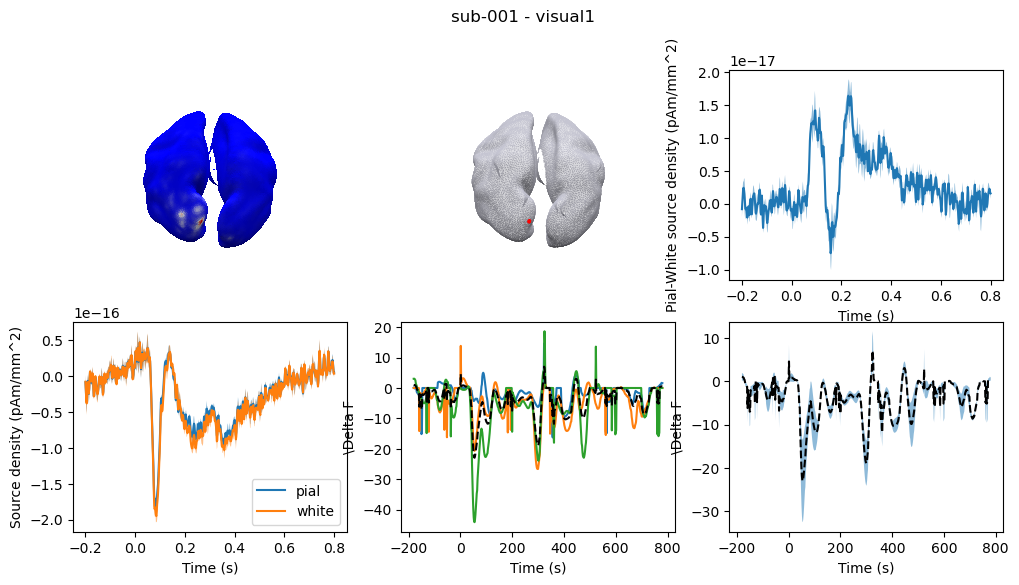

ID: sub-002
Session ses-04, Run 001: [[-29.920866  -70.9379      1.4945629]]
Session ses-04, Run 002: [[-36.38983  -63.65046  -13.402093]]
Session ses-04, Run 003: [[-36.38983  -63.65046  -13.402093]]
Session ses-05, Run 001: [[-27.927998 -71.80613    2.98596 ]]
Session ses-05, Run 002: [[-29.006443 -71.37523    3.259094]]
Session ses-05, Run 003: [[-33.375805 -64.63794  -14.950061]]
Session ses-06, Run 001: [[-29.006443 -71.37523    3.259094]]
Session ses-06, Run 002: [[-29.006443 -71.37523    3.259094]]
Session ses-06, Run 003: [[-29.006443 -71.37523    3.259094]]
Mean: [[-29.006443 -71.37523    3.259094]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


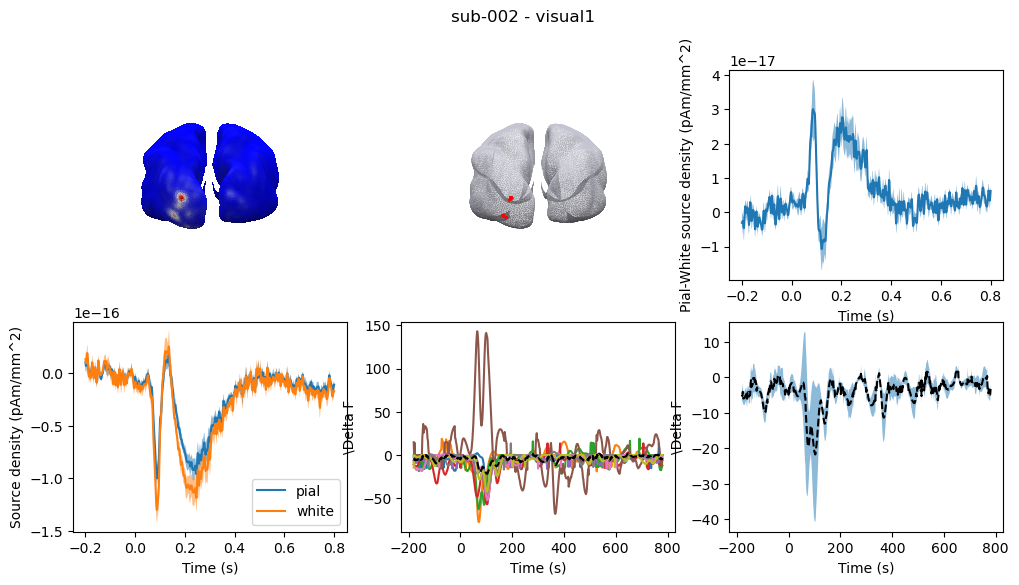

ID: sub-003
Session ses-01, Run 001: [[  5.656767 -72.726036 -16.318052]]
Session ses-01, Run 002: [[-18.60567  -70.75817  -20.470417]]
Session ses-01, Run 003: [[-18.60567  -70.75817  -20.470417]]
Session ses-02, Run 001: [[ 19.936026 -71.0799   -12.219841]]
Session ses-02, Run 002: [[ 27.92393  -54.48237  -21.408394]]
Session ses-02, Run 003: [[ 19.936026 -71.0799   -12.219841]]
Session ses-03, Run 001: [[-18.60567  -70.75817  -20.470417]]
Session ses-03, Run 002: [[ 20.006422 -70.10395  -14.74827 ]]
Session ses-03, Run 003: [[ 31.771202 -64.15593   -9.502089]]
Session ses-04, Run 001: [[-18.60567  -70.75817  -20.470417]]
Session ses-04, Run 002: [[-18.60567  -70.75817  -20.470417]]
Session ses-04, Run 003: [[ 19.936026 -71.0799   -12.219841]]
Mean: [[-18.60567  -70.75817  -20.470417]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


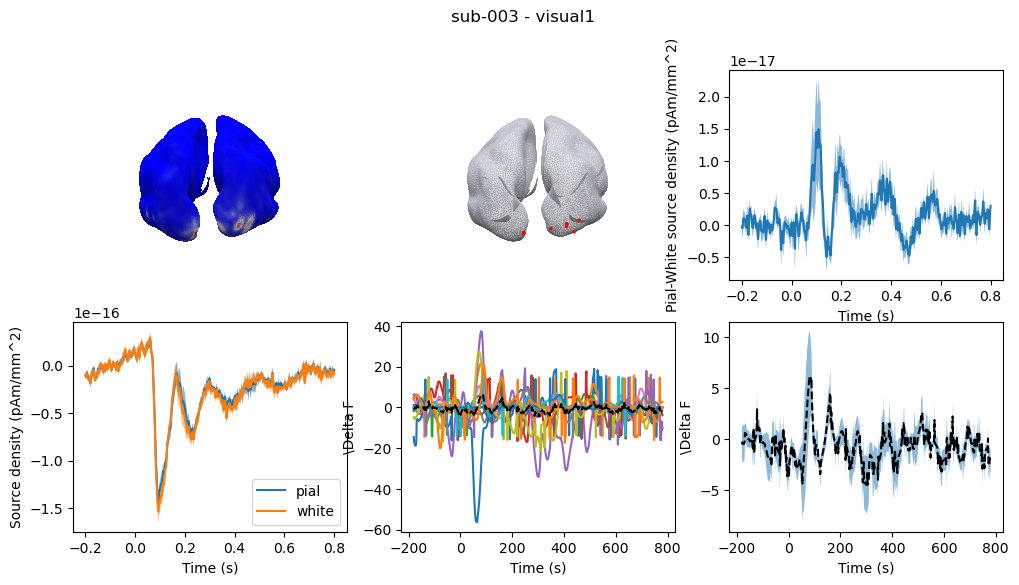

ID: sub-004
Session ses-01, Run 001: [[ 35.051395 -56.572174 -51.74465 ]]
Session ses-01, Run 002: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-01, Run 003: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-02, Run 001: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-02, Run 002: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-02, Run 003: [[ 35.051395 -56.572174 -51.74465 ]]
Session ses-03, Run 001: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-03, Run 002: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-03, Run 003: [[  3.2710826 -54.61554   -72.537155 ]]
Session ses-04, Run 001: [[-66.29584   22.800962 -70.52902 ]]
Session ses-04, Run 002: [[-20.723034 -63.820843 -77.03111 ]]
Session ses-04, Run 003: [[  3.2710826 -54.61554   -72.537155 ]]
Mean: [[  3.2710826 -54.61554   -72.537155 ]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


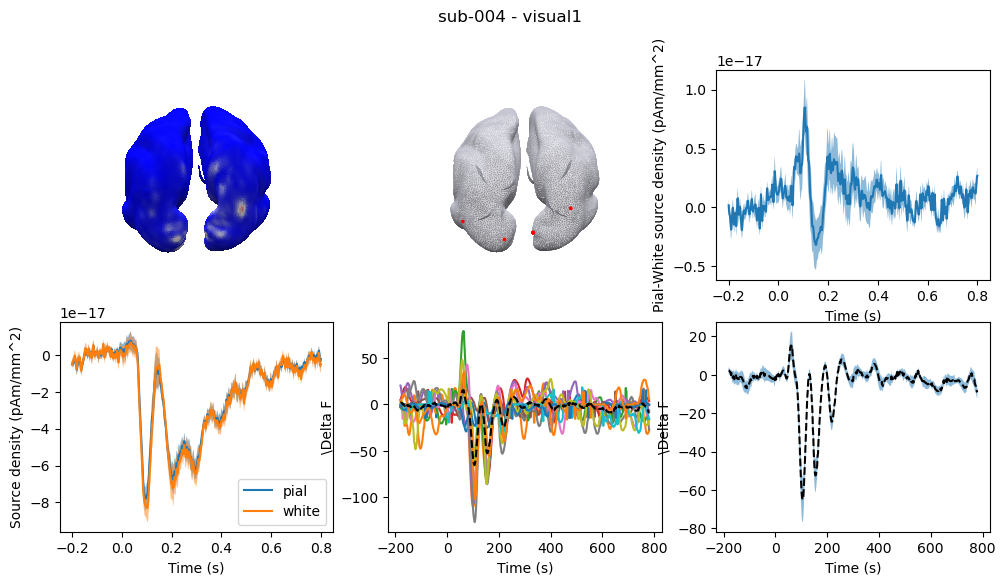

ID: sub-005
Session ses-01, Run 001: [[ -2.7862816 -63.495975  -12.025336 ]]
Session ses-01, Run 002: [[ 16.977228  -67.52471    -7.8344016]]
Session ses-01, Run 003: [[ -9.264817  -76.94805    -5.3280635]]
Session ses-02, Run 001: [[ -2.655623 -64.32623  -11.471585]]
Session ses-02, Run 002: [[ 19.09798  -62.105484 -12.022541]]
Session ses-02, Run 003: [[ 19.09798  -62.105484 -12.022541]]
Session ses-03, Run 001: [[ 19.09798  -62.105484 -12.022541]]
Session ses-03, Run 002: [[ 16.977228  -67.52471    -7.8344016]]
Session ses-03, Run 003: [[ 16.977228  -67.52471    -7.8344016]]
Session ses-04, Run 001: [[ 19.09798  -62.105484 -12.022541]]
Session ses-04, Run 002: [[ 19.09798  -62.105484 -12.022541]]
Session ses-04, Run 003: [[ 19.09798  -62.105484 -12.022541]]
Mean: [[ 19.09798  -62.105484 -12.022541]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


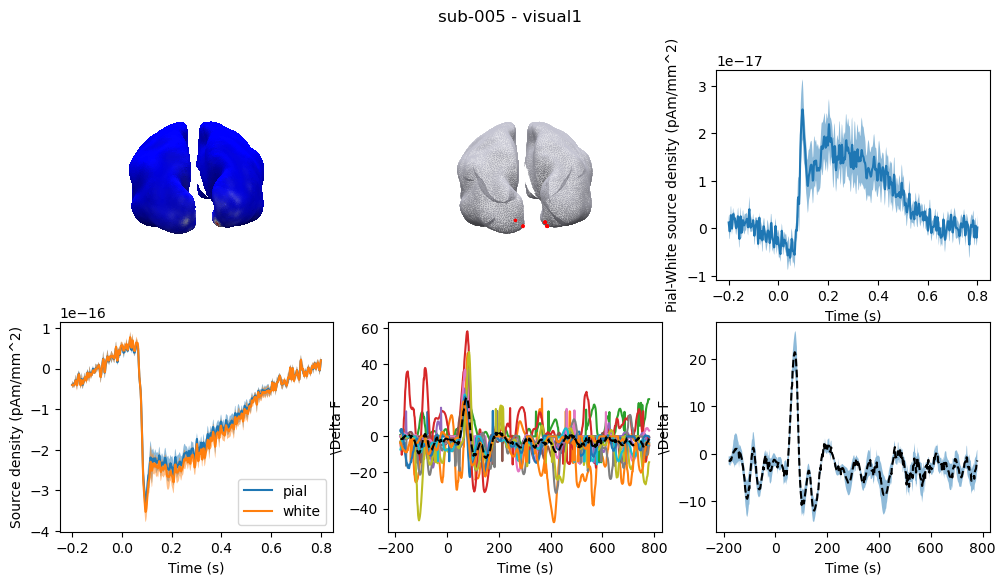

ID: sub-006
Session ses-01, Run 001: [[  6.470105  -71.86796    -1.0477005]]
Session ses-01, Run 002: [[-15.311073  -76.20743    -1.7166471]]
Session ses-01, Run 003: [[-13.755753  -75.2588     -1.5750514]]
Session ses-02, Run 001: [[-19.367329 -69.242966 -12.701476]]
Session ses-02, Run 002: [[-19.367329 -69.242966 -12.701476]]
Session ses-02, Run 003: [[ 30.895967 -59.754704 -10.949229]]
Session ses-03, Run 001: [[ 17.543623 -65.10929  -13.636245]]
Session ses-03, Run 002: [[ 30.895967 -59.754704 -10.949229]]
Session ses-03, Run 003: [[ 10.9572315 -64.127815  -11.950412 ]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Mean: [[-15.311073  -76.20743    -1.7166471]]


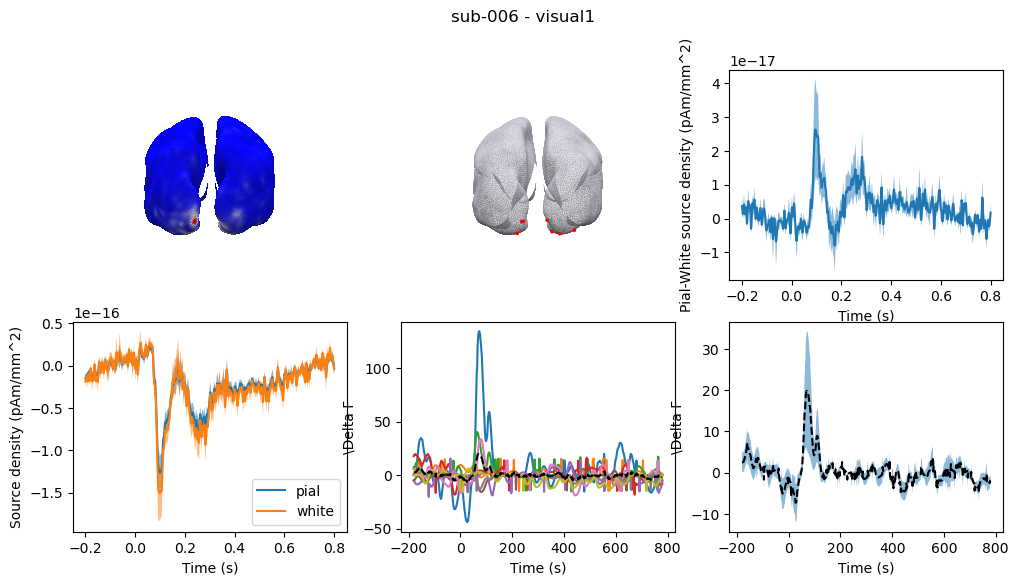

ID: sub-007
Session ses-01, Run 001: [[ -7.741798 -60.77039  -22.020576]]
Session ses-01, Run 002: [[ -7.741798 -60.77039  -22.020576]]
Session ses-01, Run 003: [[ -7.741798 -60.77039  -22.020576]]
Session ses-02, Run 001: [[-13.086518  -53.730362    1.7897141]]
Session ses-02, Run 002: [[-11.607251 -49.36275  -16.236015]]
Session ses-02, Run 003: [[ -7.990821 -59.22391  -22.205687]]


FileNotFoundError: [Errno 2] No such file or directory: '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-007/ses-02/spm/invert_fmspm_converted_autoreject-sub-007-ses-02-003-visual1-epo_tc_results.json'

In [19]:
for i in range(8):
    subj_results=load_results(i, 'visual1')
    plot_results(subj_results)

ID: sub-001
Session ses-01, Run 001: [[ -4.9317746 -55.68791   -36.411896 ]]
Session ses-01, Run 002: [[ 38.81247  -54.205444 -23.85608 ]]
Session ses-01, Run 003: [[ 15.687972 -56.159218 -23.631012]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Mean: [[ 38.81247  -54.205444 -23.85608 ]]


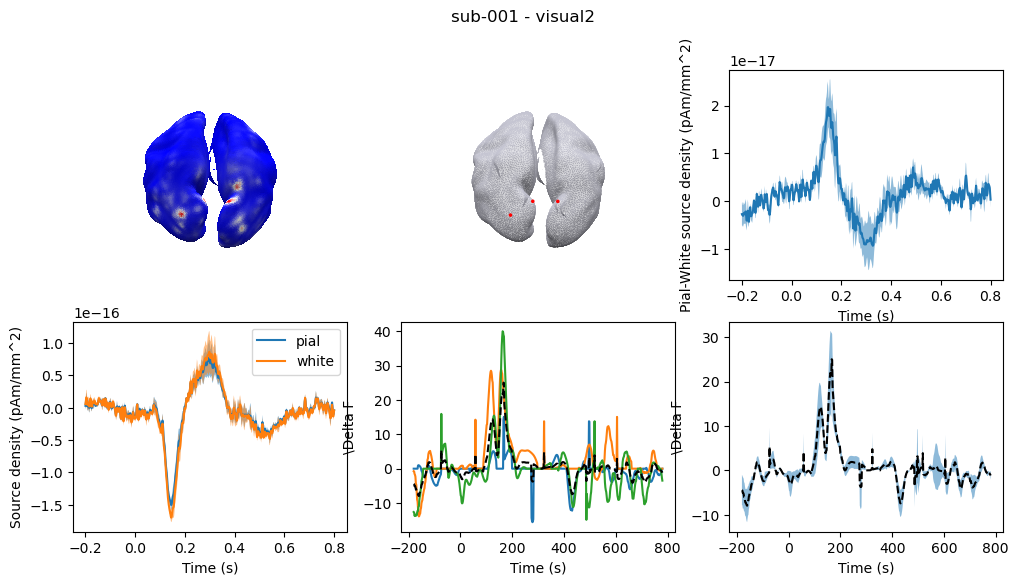

ID: sub-002
Session ses-04, Run 001: [[-24.930075 -62.304264 -23.68944 ]]
Session ses-04, Run 002: [[ 28.75941  -49.80345  -20.529514]]
Session ses-04, Run 003: [[ 33.456234 -45.325092 -20.181383]]
Session ses-05, Run 001: [[ 33.456234 -45.325092 -20.181383]]
Session ses-05, Run 002: [[-24.157772 -63.77883  -22.533724]]
Session ses-05, Run 003: [[-24.930075 -62.304264 -23.68944 ]]
Session ses-06, Run 001: [[ 33.456234 -45.325092 -20.181383]]
Session ses-06, Run 002: [[ 38.74395  -39.923615 -19.274391]]
Session ses-06, Run 003: [[ 33.456234 -45.325092 -20.181383]]
Mean: [[ 33.456234 -45.325092 -20.181383]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


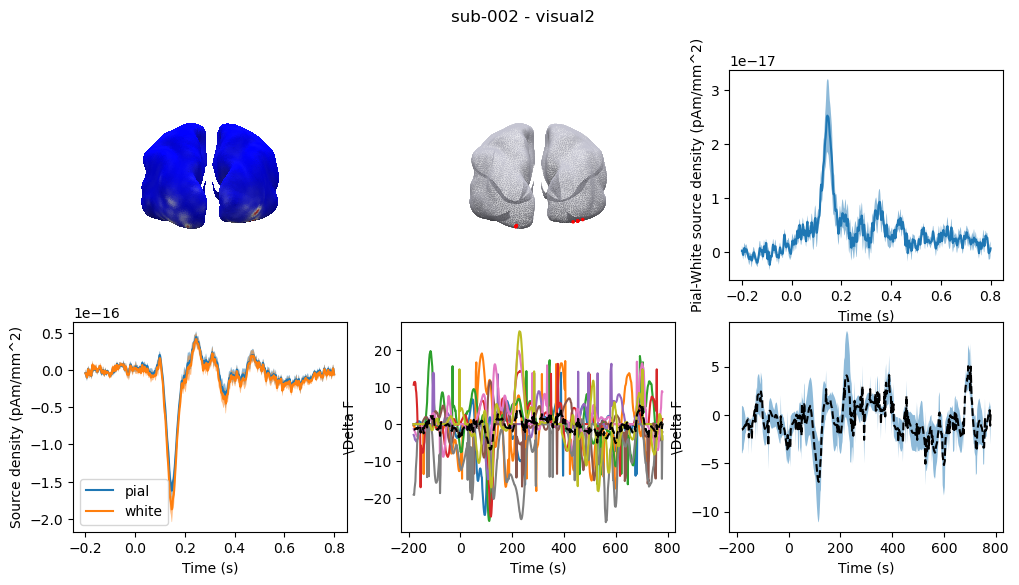

ID: sub-003
Session ses-01, Run 001: [[-41.576183 -60.10972  -24.588665]]
Session ses-01, Run 002: [[-27.444056 -64.88209  -28.396866]]
Session ses-01, Run 003: [[50.01625  66.83237  29.825369]]
Session ses-02, Run 001: [[-25.657629 -64.29731  -28.413908]]
Session ses-02, Run 002: [[-26.996456 -64.31248  -28.588999]]
Session ses-02, Run 003: [[-25.657629 -64.29731  -28.413908]]
Session ses-03, Run 001: [[-25.928993 -62.998928 -28.779165]]
Session ses-03, Run 002: [[-22.458723 -55.59993  -24.784706]]
Session ses-03, Run 003: [[-25.657629 -64.29731  -28.413908]]
Session ses-04, Run 001: [[-25.928993 -62.998928 -28.779165]]
Session ses-04, Run 002: [[-25.928993 -62.998928 -28.779165]]
Session ses-04, Run 003: [[-25.657629 -64.29731  -28.413908]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Mean: [[-25.657629 -64.29731  -28.413908]]


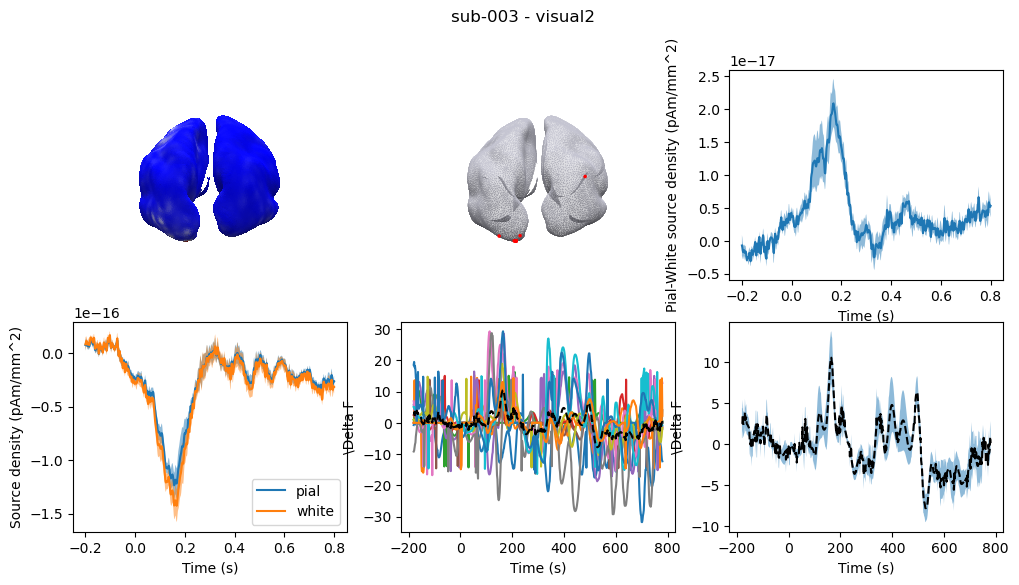

ID: sub-004
Session ses-01, Run 001: [[ 21.192509 -55.677235 -82.76813 ]]
Session ses-01, Run 002: [[ 21.192509 -55.677235 -82.76813 ]]
Session ses-01, Run 003: [[ 21.192509 -55.677235 -82.76813 ]]
Session ses-02, Run 001: [[ 19.00857  -59.945065 -71.93723 ]]
Session ses-02, Run 002: [[ 19.677979 -56.33546  -82.71316 ]]
Session ses-02, Run 003: [[ 19.677979 -56.33546  -82.71316 ]]
Session ses-03, Run 001: [[ 21.192509 -55.677235 -82.76813 ]]
Session ses-03, Run 002: [[ 19.6175   -55.901833 -83.28776 ]]
Session ses-03, Run 003: [[ 19.6175   -55.901833 -83.28776 ]]
Session ses-04, Run 001: [[ 19.6175   -55.901833 -83.28776 ]]
Session ses-04, Run 002: [[ 19.00857  -59.945065 -71.93723 ]]
Session ses-04, Run 003: [[ 19.6175   -55.901833 -83.28776 ]]
Mean: [[ 19.6175   -55.901833 -83.28776 ]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


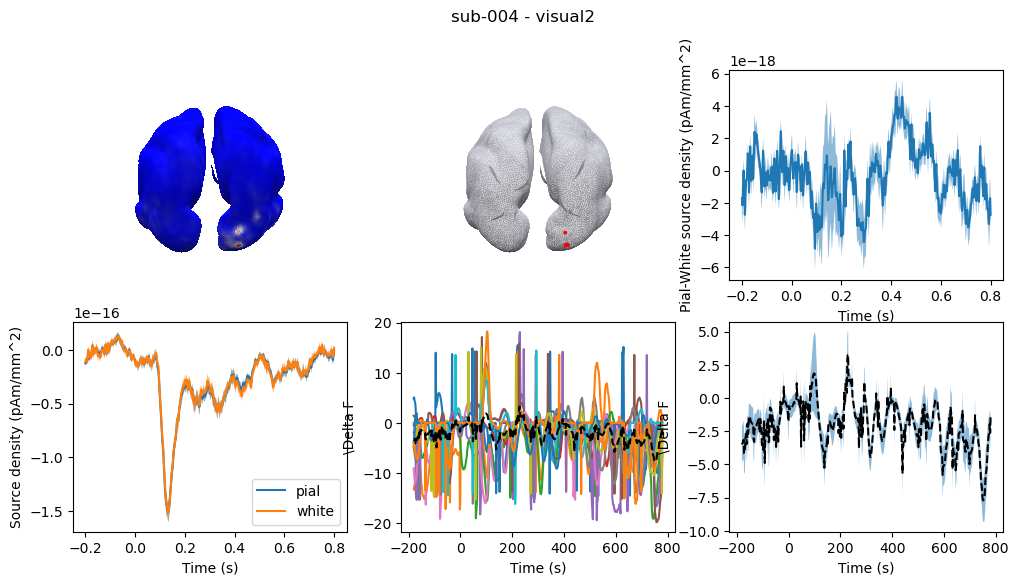

ID: sub-005
Session ses-01, Run 001: [[-19.445515 -68.61529  -16.850994]]
Session ses-01, Run 002: [[-53.29904    39.379124   -2.8495724]]
Session ses-01, Run 003: [[-52.470043  40.084743  -4.209162]]
Session ses-02, Run 001: [[ 56.14908   27.112347 -11.39728 ]]
Session ses-02, Run 002: [[ 56.14908   27.112347 -11.39728 ]]
Session ses-02, Run 003: [[ 56.14908   27.112347 -11.39728 ]]
Session ses-03, Run 001: [[-53.29904    39.379124   -2.8495724]]
Session ses-03, Run 002: [[-53.29904    39.379124   -2.8495724]]
Session ses-03, Run 003: [[-53.29904    39.379124   -2.8495724]]
Session ses-04, Run 001: [[-41.20355  -52.692123  -9.155601]]
Session ses-04, Run 002: [[-41.20355  -52.692123  -9.155601]]
Session ses-04, Run 003: [[-53.29904    39.379124   -2.8495724]]
Mean: [[ 56.14908   27.112347 -11.39728 ]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


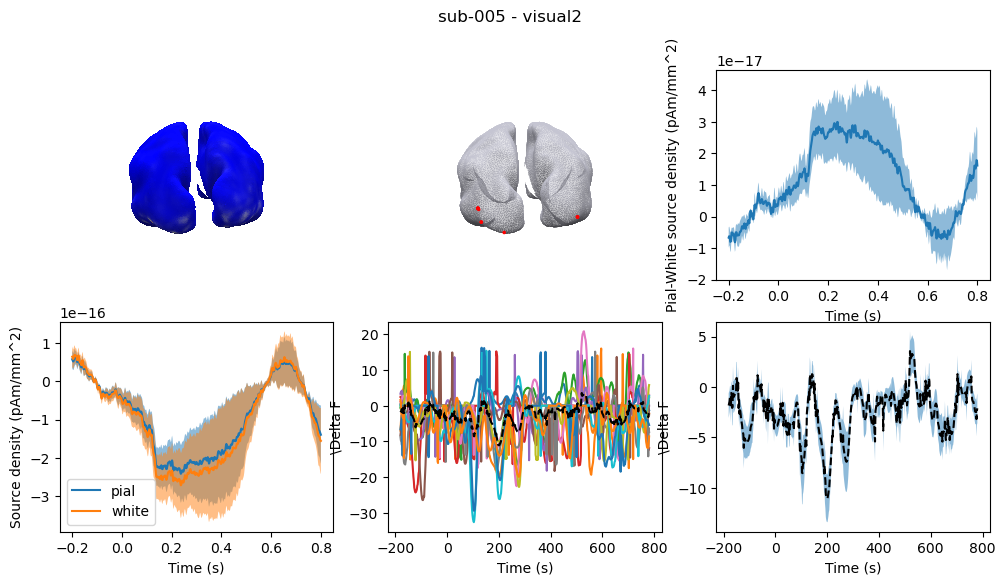

ID: sub-006
Session ses-01, Run 001: [[-53.51175    34.56877    -2.7910235]]
Session ses-01, Run 002: [[-9.483268 53.94801   9.562279]]
Session ses-01, Run 003: [[-53.51175    34.56877    -2.7910235]]
Session ses-02, Run 001: [[-9.483268 53.94801   9.562279]]
Session ses-02, Run 002: [[-53.51175    34.56877    -2.7910235]]
Session ses-02, Run 003: [[ 30.895967 -59.754704 -10.949229]]
Session ses-03, Run 001: [[-53.51175    34.56877    -2.7910235]]
Session ses-03, Run 002: [[ 30.895967 -59.754704 -10.949229]]
Session ses-03, Run 003: [[-53.51175    34.56877    -2.7910235]]
Mean: [[-53.51175    34.56877    -2.7910235]]


/home/bonaiuto/miniconda3/envs/laminar_erf/lib/python3.7/site-packages/ipykernel_launcher.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


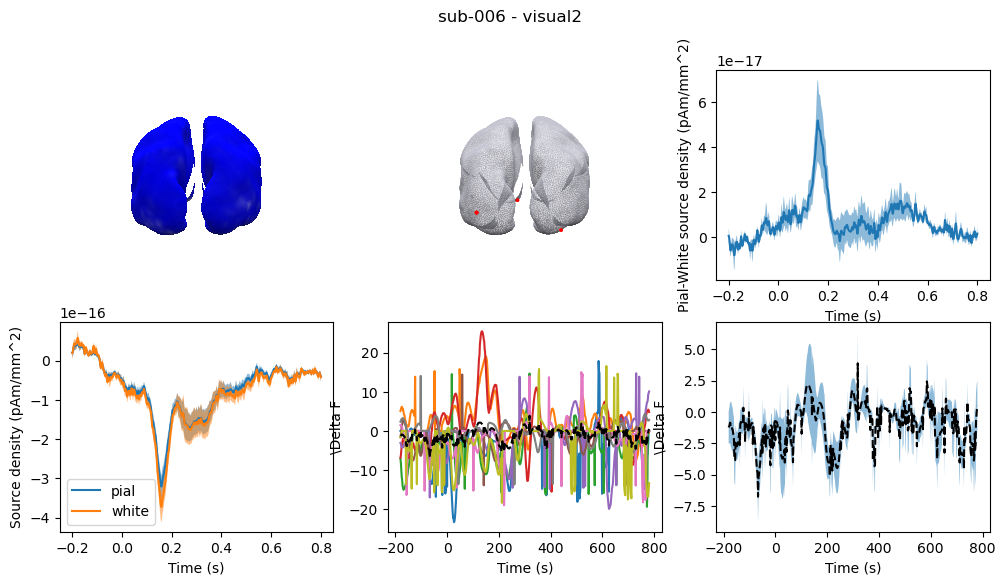

ID: sub-007
Session ses-01, Run 001: [[ 29.867098 -45.15927  -23.25642 ]]
Session ses-01, Run 002: [[ 20.461329 -58.043346 -25.758436]]
Session ses-01, Run 003: [[ 20.461329 -58.043346 -25.758436]]
Session ses-02, Run 001: [[ 29.867098 -45.15927  -23.25642 ]]
Session ses-02, Run 002: [[ 30.395144 -46.078976 -23.066101]]


FileNotFoundError: [Errno 2] No such file or directory: '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-007/ses-02/spm/invert_fmspm_converted_autoreject-sub-007-ses-02-002-visual2-epo_tc_results.json'

In [21]:
for i in range(8):
    subj_results=load_results(i, 'visual2')
    plot_results(subj_results)

ID: sub-001
Session ses-01, Run 001: [[-25.829117     0.25887045  44.443745  ]]
Session ses-01, Run 002: [[-25.829117     0.25887045  44.443745  ]]
Session ses-01, Run 003: [[-25.829117     0.25887045  44.443745  ]]
Mean: [[-25.829117     0.25887045  44.443745  ]]


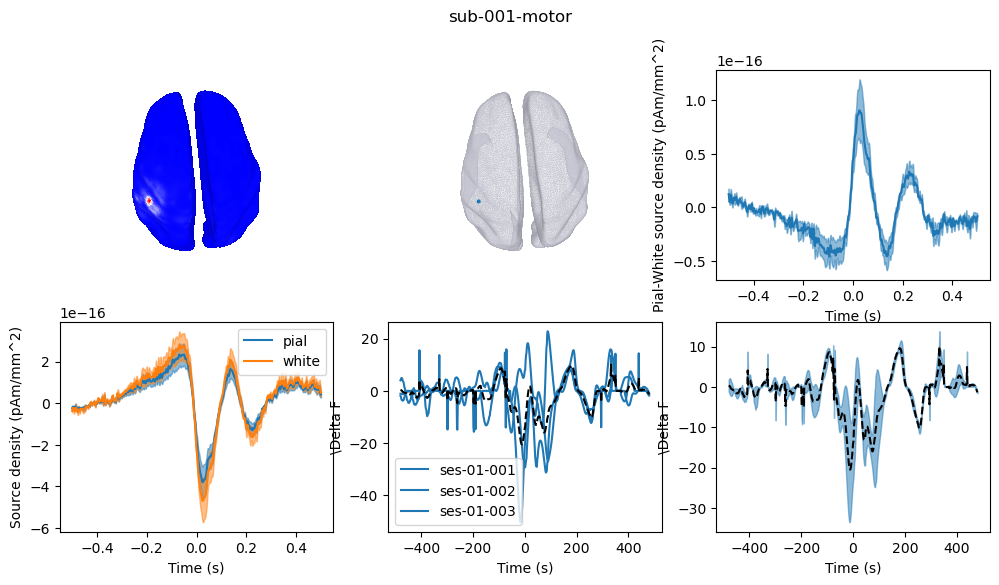

ID: sub-002
Session ses-04, Run 001: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-04, Run 002: [[-55.037006   -6.4715533  61.38838  ]]
Session ses-04, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-05, Run 001: [[-53.197227  -5.604995  61.257534]]
Session ses-05, Run 002: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-05, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 001: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 002: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Mean: [[-57.079548   -5.4908967  60.012653 ]]


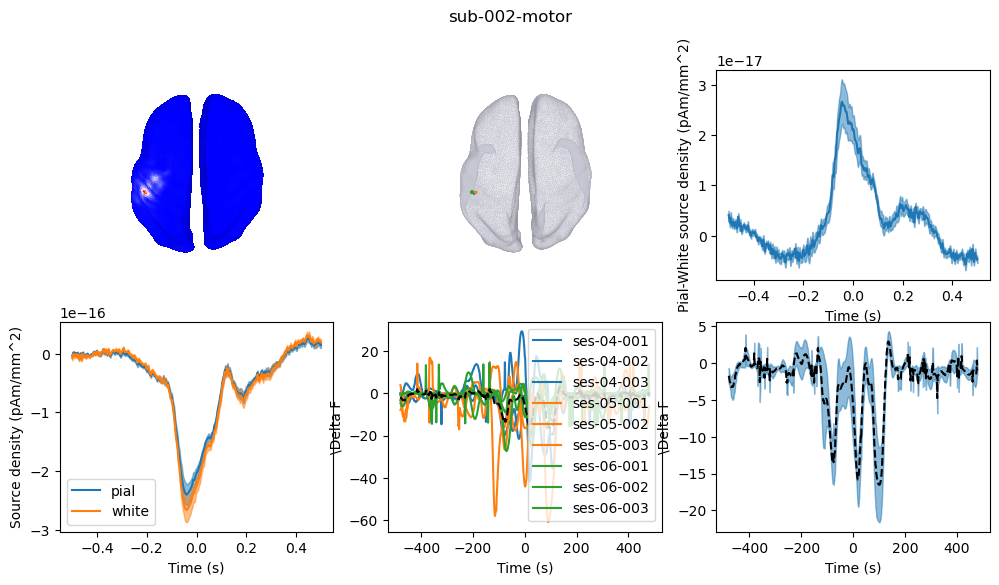

ID: sub-003
Session ses-01, Run 001: [[-52.68968  -16.596676  68.41617 ]]
Session ses-01, Run 002: [[-51.547375 -17.936907  69.099464]]
Session ses-01, Run 003: [[-45.44868  -10.734605  77.19698 ]]
Session ses-02, Run 001: [[-49.598305 -16.644867  70.14545 ]]
Session ses-02, Run 002: [[-50.307503 -18.170053  69.82004 ]]
Session ses-02, Run 003: [[-50.307503 -18.170053  69.82004 ]]
Session ses-03, Run 001: [[-51.964924 -24.057478  64.925186]]
Session ses-03, Run 002: [[-51.964924 -24.057478  64.925186]]
Session ses-03, Run 003: [[-51.964924 -24.057478  64.925186]]
Session ses-04, Run 001: [[-50.307503 -18.170053  69.82004 ]]
Session ses-04, Run 002: [[-49.598305 -16.644867  70.14545 ]]
Session ses-04, Run 003: [[-51.858955    -0.69440633  72.6979    ]]
Mean: [[-50.307503 -18.170053  69.82004 ]]


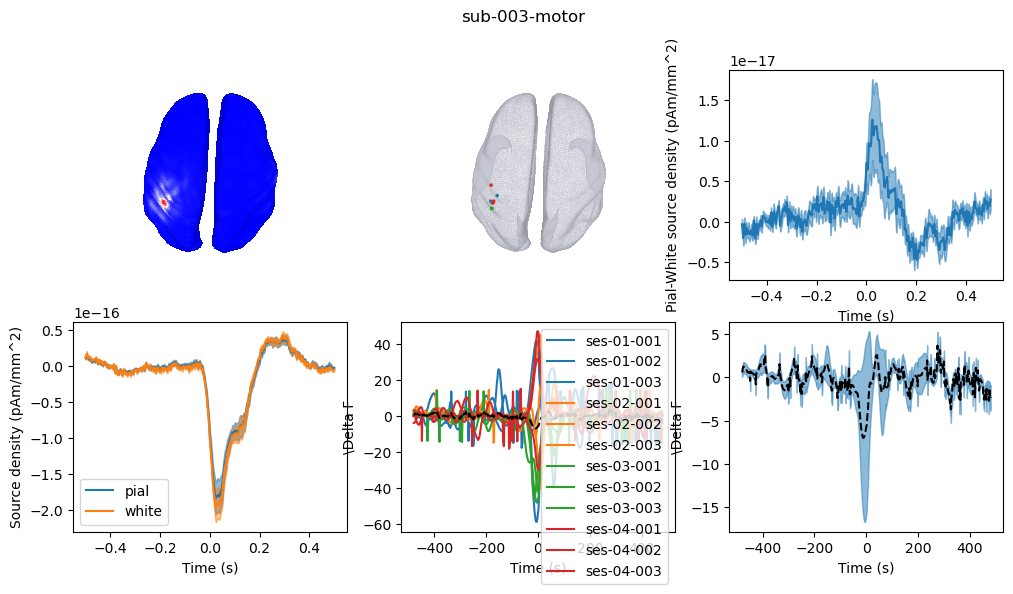

ID: sub-004
Session ses-01, Run 001: [[ 47.58465  -17.014809  15.813034]]
Session ses-01, Run 002: [[-48.030228 -28.015253  17.466743]]
Session ses-01, Run 003: [[-48.030228 -28.015253  17.466743]]
Session ses-02, Run 001: [[-48.030228 -28.015253  17.466743]]
Session ses-02, Run 002: [[ 47.58465  -17.014809  15.813034]]


FileNotFoundError: [Errno 2] No such file or directory: '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-004/ses-02/spm/invert_fmspm_converted_autoreject-sub-004-ses-02-002-motor-epo_tc_results.json'

In [41]:
for i in range(8):
    plot_results(i, 'motor')

ID: sub-001
Session ses-01, Run 001: [[-27.78036     0.5524372  43.2748   ]]
Session ses-01, Run 002: [[-27.78036     0.5524372  43.2748   ]]
Session ses-01, Run 003: [[-25.829117     0.25887045  44.443745  ]]
Mean: [[-25.829117     0.25887045  44.443745  ]]


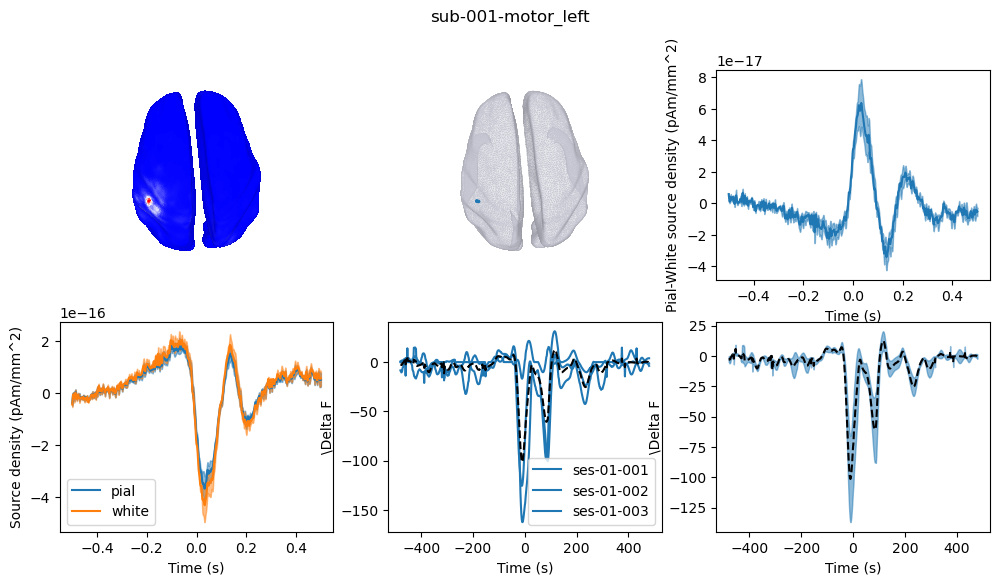

ID: sub-002
Session ses-04, Run 001: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-04, Run 002: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-04, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-05, Run 001: [[-55.037006   -6.4715533  61.38838  ]]
Session ses-05, Run 002: [[-56.37041    -5.1923265  60.20386  ]]
Session ses-05, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 001: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 002: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Mean: [[-57.079548   -5.4908967  60.012653 ]]


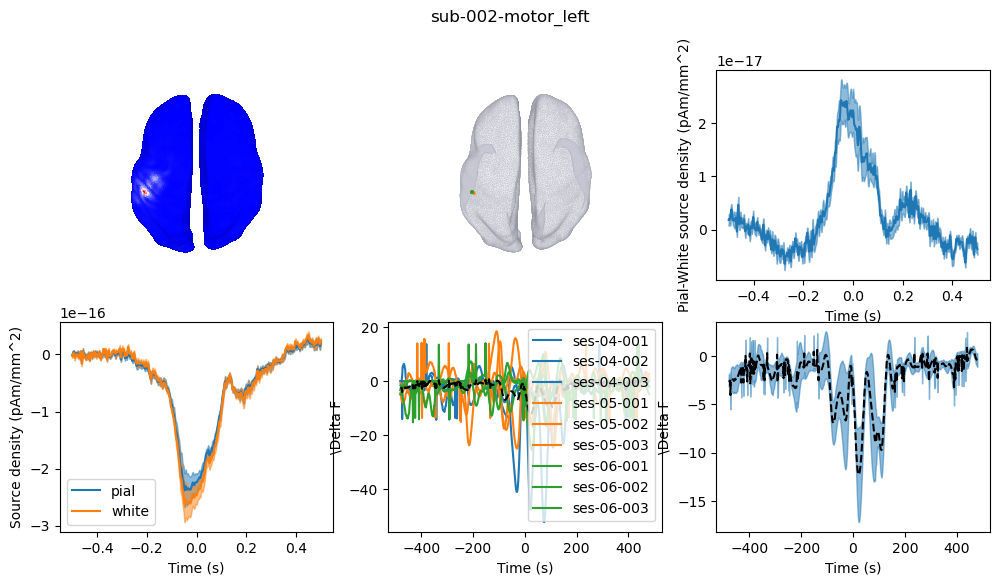

ID: sub-003
Session ses-01, Run 001: [[-52.68968  -16.596676  68.41617 ]]
Session ses-01, Run 002: [[-51.547375 -17.936907  69.099464]]
Session ses-01, Run 003: [[-50.307503 -18.170053  69.82004 ]]
Session ses-02, Run 001: [[-49.598305 -16.644867  70.14545 ]]
Session ses-02, Run 002: [[-43.822548 -13.358134  77.455284]]
Session ses-02, Run 003: [[-49.20667  -18.132751  70.41908 ]]
Session ses-03, Run 001: [[-49.598305 -16.644867  70.14545 ]]
Session ses-03, Run 002: [[-51.964924 -24.057478  64.925186]]
Session ses-03, Run 003: [[-51.964924 -24.057478  64.925186]]
Session ses-04, Run 001: [[-49.598305 -16.644867  70.14545 ]]
Session ses-04, Run 002: [[-51.964924 -24.057478  64.925186]]
Session ses-04, Run 003: [[-51.858955    -0.69440633  72.6979    ]]
Mean: [[-50.307503 -18.170053  69.82004 ]]


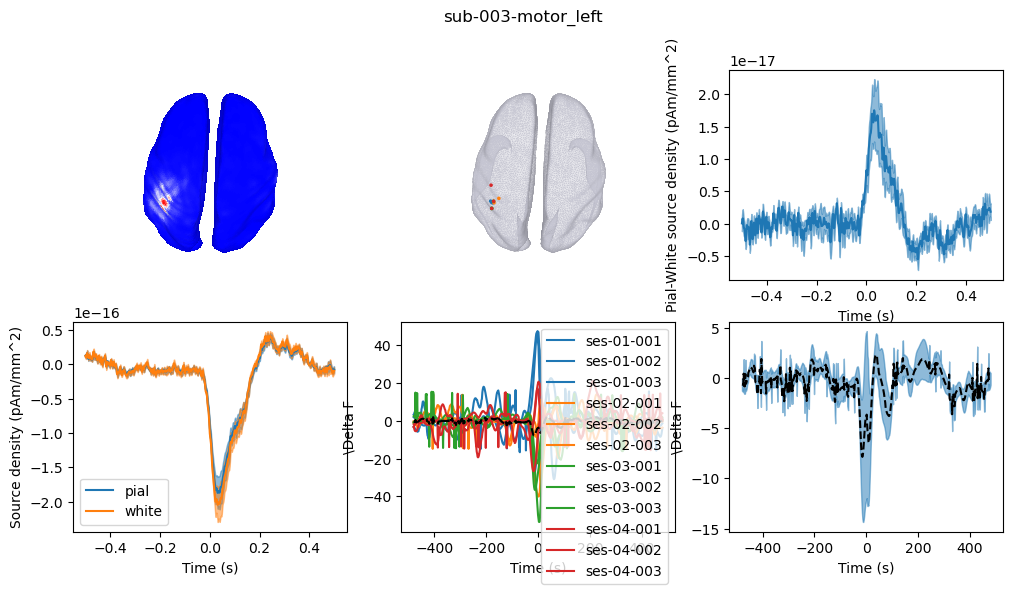

ID: sub-004
Session ses-01, Run 001: [[ 47.58465  -17.014809  15.813034]]
Session ses-01, Run 002: [[-48.030228 -28.015253  17.466743]]
Session ses-01, Run 003: [[-48.030228 -28.015253  17.466743]]
Session ses-02, Run 001: [[-48.030228 -28.015253  17.466743]]
Session ses-02, Run 002: [[-48.855347 -27.829874  17.023483]]


FileNotFoundError: [Errno 2] No such file or directory: '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-004/ses-02/spm/invert_fmspm_converted_autoreject-sub-004-ses-02-002-motor_left-epo_tc_results.json'

In [42]:
for i in range(8):
    plot_results(i, 'motor_left')

ID: sub-001
Session ses-01, Run 001: [[-27.78036     0.5524372  43.2748   ]]
Session ses-01, Run 002: [[-25.829117     0.25887045  44.443745  ]]
Session ses-01, Run 003: [[-25.829117     0.25887045  44.443745  ]]
Mean: [[-25.829117     0.25887045  44.443745  ]]


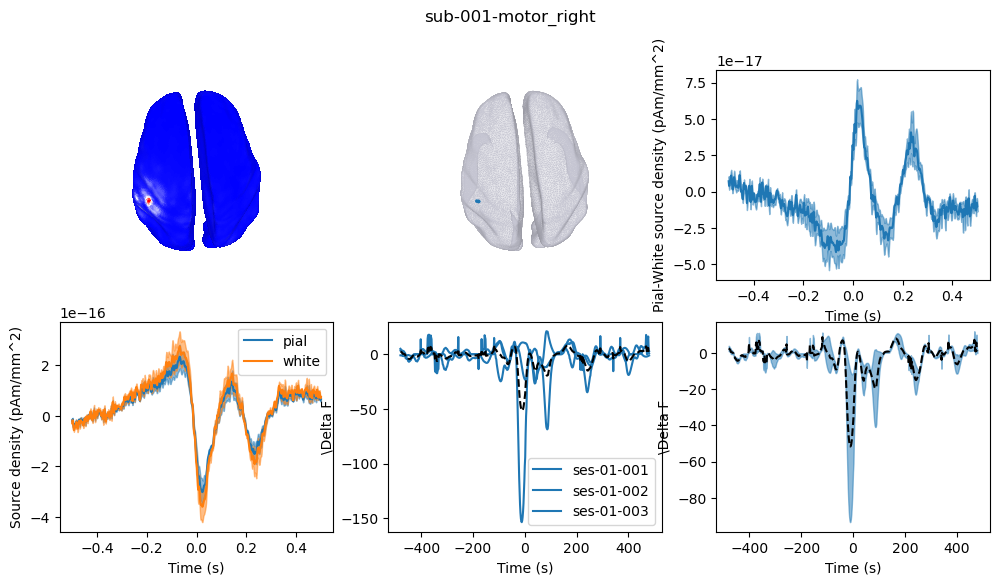

ID: sub-002
Session ses-04, Run 001: [[-53.743774   -7.7398624  62.50083  ]]
Session ses-04, Run 002: [[-55.037006   -6.4715533  61.38838  ]]
Session ses-04, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-05, Run 001: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-05, Run 002: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-05, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 001: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 002: [[-57.079548   -5.4908967  60.012653 ]]
Session ses-06, Run 003: [[-57.079548   -5.4908967  60.012653 ]]
Mean: [[-57.079548   -5.4908967  60.012653 ]]


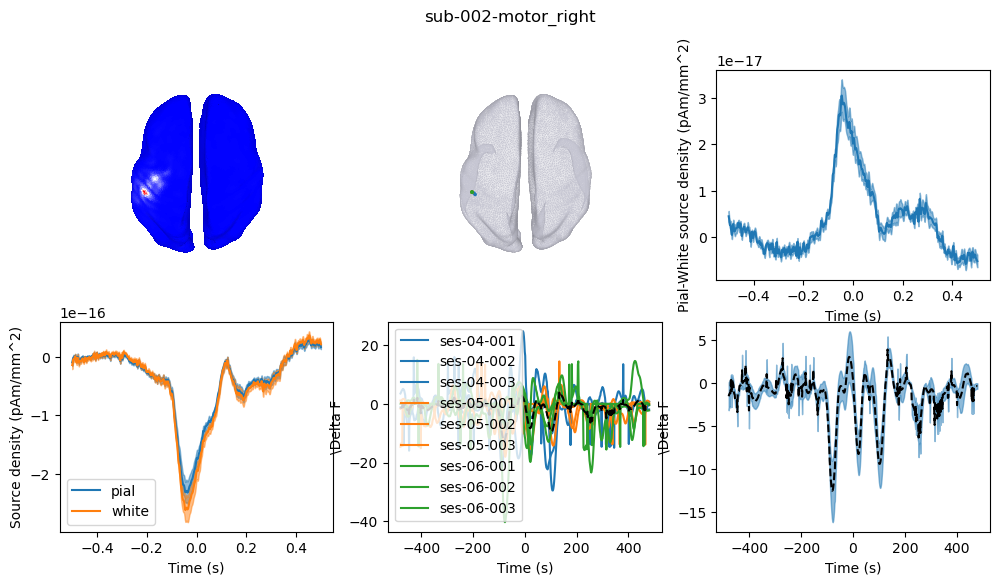

ID: sub-003
Session ses-01, Run 001: [[50.01625  66.83237  29.825369]]
Session ses-01, Run 002: [[-51.547375 -17.936907  69.099464]]
Session ses-01, Run 003: [[-51.547375 -17.936907  69.099464]]
Session ses-02, Run 001: [[-50.307503 -18.170053  69.82004 ]]
Session ses-02, Run 002: [[-49.20667  -18.132751  70.41908 ]]
Session ses-02, Run 003: [[-50.307503 -18.170053  69.82004 ]]
Session ses-03, Run 001: [[-49.598305 -16.644867  70.14545 ]]
Session ses-03, Run 002: [[-50.307503 -18.170053  69.82004 ]]
Session ses-03, Run 003: [[-51.547375 -17.936907  69.099464]]
Session ses-04, Run 001: [[-51.547375 -17.936907  69.099464]]
Session ses-04, Run 002: [[-51.547375 -17.936907  69.099464]]
Session ses-04, Run 003: [[50.01625  66.83237  29.825369]]
Mean: [[-51.547375 -17.936907  69.099464]]


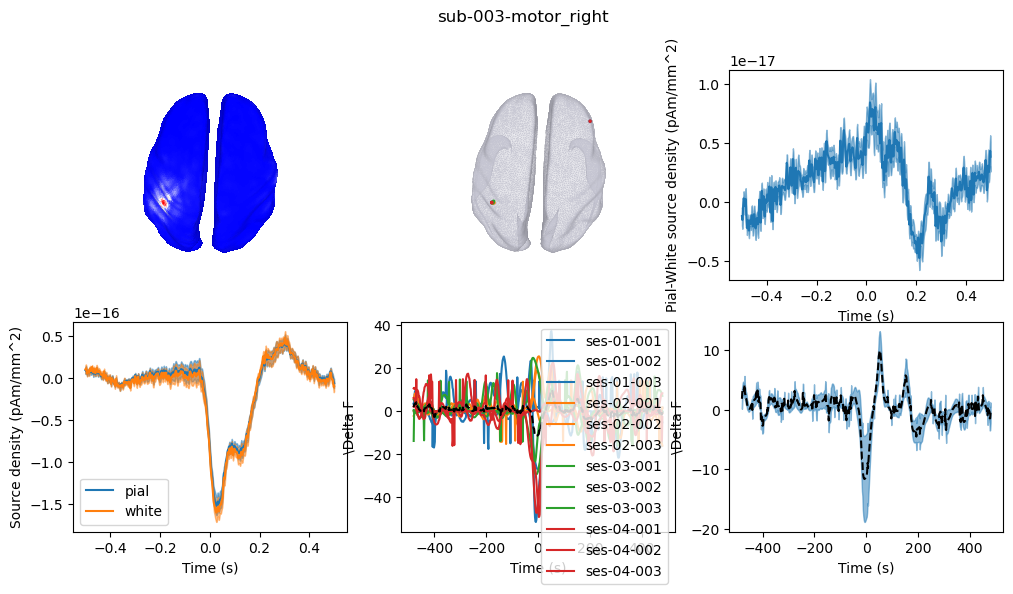

ID: sub-004
Session ses-01, Run 001: [[-48.030228 -28.015253  17.466743]]
Session ses-01, Run 002: [[-48.855347 -27.829874  17.023483]]
Session ses-01, Run 003: [[-48.030228 -28.015253  17.466743]]
Session ses-02, Run 001: [[-48.855347 -27.829874  17.023483]]
Session ses-02, Run 002: [[ 47.58465  -17.014809  15.813034]]


FileNotFoundError: [Errno 2] No such file or directory: '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-004/ses-02/spm/invert_fmspm_converted_autoreject-sub-004-ses-02-002-motor_right-epo_tc_results.json'

In [43]:
for i in range(8):
    plot_results(i, 'motor_right')